In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 30.0 MB/s 


In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings; warnings.filterwarnings('ignore')
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [3]:
!gdown --id 1diztKyKFfhINpY-8R_KB84kV8akW2NjD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1diztKyKFfhINpY-8R_KB84kV8akW2NjD
To: /content/test_train_val.zip
100% 480M/480M [00:04<00:00, 109MB/s]


In [4]:
!unzip -qq test_train_val.zip

In [5]:
with open('test_train_val/train_meta.csv') as f:
  train_df= pd.read_csv(f)
with open('test_train_val/train_signal.csv') as f:
  train_signal = pd.read_csv(f)

with open('test_train_val/valid_meta.csv') as f:
  valid_df= pd.read_csv(f)
with open('test_train_val/valid_signal.csv') as f:
  valid_signal = pd.read_csv(f)

with open('test_train_val/test_meta.csv') as f:
  test_df= pd.read_csv(f)
with open('test_train_val/test_signal.csv') as f:
  test_signal = pd.read_csv(f)

print(train_df.shape)

train_df

(17441, 37)


,ecg_id,age,sex,height,weight,nurse,site,device,NORM,MI,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
0,1,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
1,2,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,2
2,3,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,5
3,4,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
4,5,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,21832,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17437,21833,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17438,21834,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,...,0,0,0,0,0,0,0,0,0,4
17439,21835,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,2


In [6]:
class PTBXLDatasetPreprocesser():
    def __init__(self):
        pass
    
    def save(self, filename):
        data = {
            'superclass_cols': self.superclass_cols,
            'subclass_cols': self.subclass_cols,
            'meta_num_cols': self.meta_num_cols,
            'meta_num_means': self.meta_num_means,
            'min_max_scaler': self.min_max_scaler,
            'meta_cat_cols': self.meta_cat_cols,
            'cat_lablers': self.cat_lablers,
            
        }
        pd.to_pickle(data, filename)
        
    def load(self, filename):
        data = pd.read_pickle(filename)
        self.min_max_scaler = data['min_max_scaler']
        self.cat_lablers = data['cat_lablers']
        
        
    def fit(self, x, y):
        x = x.copy()
        y = y.copy()
        
        self.superclass_cols = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
        
        self.subclass_cols = [col for col in y.columns if 'sub_' in col]

        
        
        self.meta_num_cols = ['age', 'height', 'weight']
        self.meta_num_means = []
        for col in self.meta_num_cols:
            print(col, y[col].mean())
            y[col] = y[col].fillna(y[col].mean())
            self.meta_num_means += [y[col].mean()]
            
        self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        self.meta_cat_cols = ['sex'] #, 'nurse', 'device']
        self.cat_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_cat_cols]
        return self

        
    def transform(self, x, y):
        
        channel_cols = x.columns.tolist()[1:]
        
        ret = []
        x = x[channel_cols].values.reshape(-1, 1000, 12)
        print(x.shape)
        ret += [x] # signal
        
        y_ = y.copy()
        
        for i, col in enumerate(self.meta_num_cols):
            y_[col] = y_[col].fillna(self.meta_num_means[i])
        y_[self.meta_num_cols] = self.min_max_scaler.transform(y_[self.meta_num_cols])
        y_[self.meta_num_cols] = np.clip(y_[self.meta_num_cols], 0., 1.) # prevent extreme value far from train set
        
        ret += [y_[self.meta_num_cols]] # meta num features
        
        for i, col in enumerate(self.meta_cat_cols):
            y_[col] = y_[col].fillna('none').astype(str)
            y_[col] = self.cat_lablers[i].transform(y_[col]) 
        
        ret += [y_[self.meta_cat_cols]] # meta cat features

        
        
        if np.isin(self.superclass_cols, y.columns).sum() == len(self.superclass_cols):
            ret += [y[self.superclass_cols].fillna(0).astype(int)] # superclass targets
        
        if np.isin(self.subclass_cols, y.columns).sum() == len(self.subclass_cols):
            ret += [y[self.subclass_cols].fillna(0).astype(int)] # subclass targets

        
        return ret

In [7]:
data_preprocessor = PTBXLDatasetPreprocesser()
data_preprocessor.fit(train_signal, train_df)
train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass = data_preprocessor.transform(train_signal, train_df)
valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass = data_preprocessor.transform(valid_signal, valid_df)
test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass = data_preprocessor.transform(test_signal, test_df)

print(train_signal.shape)
print(valid_meta_num_feats.isna().sum(), valid_meta_cat_feats.isna().sum(), valid_superclass.isna().sum(), valid_subclass.isna().sum())

display(train_meta_num_feats)
display(train_meta_cat_feats)
display(train_superclass)
display(train_subclass)

age 59.63709074169975
height 166.68908469699693
weight 70.69599447513812
(17441, 1000, 12)
(2193, 1000, 12)
(2203, 1000, 12)
(17441, 1000, 12)
age       0
height    0
weight    0
dtype: int64 sex    0
dtype: int64 NORM    0
MI      0
STTC    0
CD      0
HYP     0
dtype: int64 sub_NORM         0
sub_IMI          0
sub_STTC         0
sub_NST_         0
sub_LVH          0
sub_LAFB/LPFB    0
sub_RVH          0
sub_RAO/RAE      0
sub_IRBBB        0
sub_IVCD         0
sub_LMI          0
sub_AMI          0
sub__AVB         0
sub_ISCA         0
sub_ISC_         0
sub_SEHYP        0
sub_ISCI         0
sub_CRBBB        0
sub_CLBBB        0
sub_LAO/LAE      0
sub_ILBBB        0
sub_WPW          0
sub_PMI          0
dtype: int64


,age,height,weight
0,0.580645,0.791572,0.282927
1,0.182796,0.791572,0.317073
2,0.376344,0.791572,0.312195
3,0.236559,0.791572,0.375610
4,0.182796,0.791572,0.317073
...,...,...,...
17436,0.655914,0.791572,0.320468
17437,0.698925,0.791572,0.320468
17438,0.978495,0.791572,0.320468
17439,0.612903,0.791572,0.320468


,sex
0,1
1,0
2,1
3,0
4,1
...,...
17436,0
17437,1
17438,0
17439,1


,NORM,MI,STTC,CD,HYP
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
17436,0,0,0,1,0
17437,0,0,1,0,0
17438,1,0,0,0,0
17439,0,0,1,0,0


,sub_NORM,sub_IMI,sub_STTC,sub_NST_,sub_LVH,sub_LAFB/LPFB,sub_RVH,sub_RAO/RAE,sub_IRBBB,sub_IVCD,...,sub_ISCA,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17437,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17438,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17439,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [8]:
signal=np.array(train_signal)

In [9]:
target=np.array(train_subclass)
target.shape

(17441, 23)

In [10]:
v_signal=np.array(valid_signal)

In [11]:
v_target=np.array(valid_subclass)
v_target.shape

(2193, 23)

In [12]:
!pip install ecg-plot
#import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional
from keras.models import Sequential, Model
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.layers.merge import concatenate
from scipy import optimize
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload
%reload_ext autoreload

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**5 MultiClass Classification**

**ANN Model**

In [13]:
ann_model = Sequential()
ann_model.add(Dense(50, activation='relu', input_shape=(1000,12)))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(23, activation='sigmoid'))

In [14]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

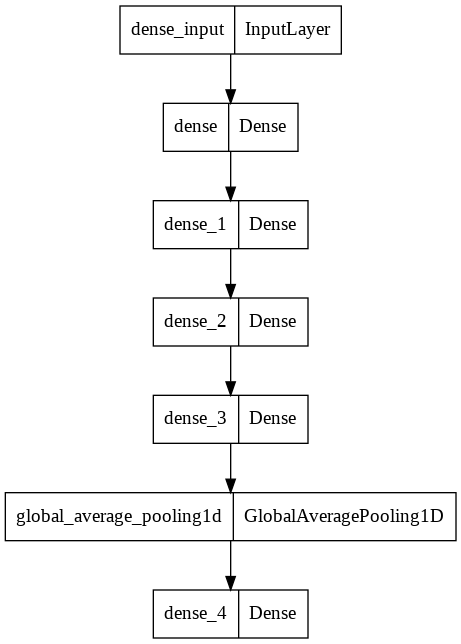

In [15]:
plot_model(ann_model)

In [16]:
batchsize = 10
ann_model.fit(x=signal, y=target, batch_size=batchsize, epochs=10, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/10
1396/1396 [==============================] - 28s 16ms/step - loss: 0.1791 - accuracy: 0.9428 - Recall: 0.1976 - Precision: 0.5720 - AUC: 0.6304 - val_loss: 0.1652 - val_accuracy: 0.9436 - val_Recall: 0.2396 - val_Precision: 0.6066 - val_AUC: 0.6932
Epoch 2/10
1396/1396 [==============================] - 20s 15ms/step - loss: 0.1471 - accuracy: 0.9506 - Recall: 0.2856 - Precision: 0.7276 - AUC: 0.7217 - val_loss: 0.1545 - val_accuracy: 0.9469 - val_Recall: 0.2894 - val_Precision: 0.6551 - val_AUC: 0.7314
Epoch 3/10
1396/1396 [==============================] - 12s 9ms/step - loss: 0.1404 - accuracy: 0.9525 - Recall: 0.3174 - Precision: 0.7475 - AUC: 0.7491 - val_loss: 0.1481 - val_accuracy: 0.9486 - val_Recall: 0.2764 - val_Precision: 0.7126 - val_AUC: 0.7578
Epoch 4/10
1396/1396 [==============================] - 12s 8ms/step - loss: 0.1366 - accuracy: 0.9533 - Recall: 0.3342 - Precision: 0.7528 - AUC: 0.7671 - val_loss: 0.1473 - val_accuracy: 0.9475 - val_Recall: 0.3138 - va

Text(0, 0.5, 'Accuracy')

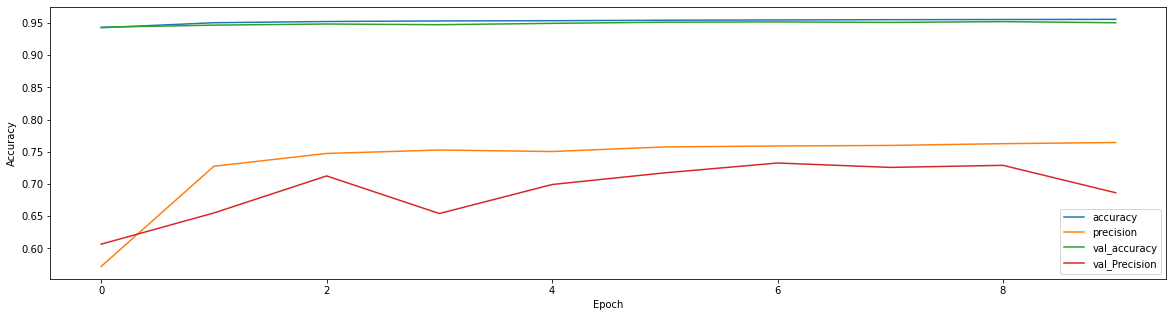

In [17]:
plt.plot(ann_model.history.history['accuracy'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['val_accuracy'])
plt.plot(ann_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

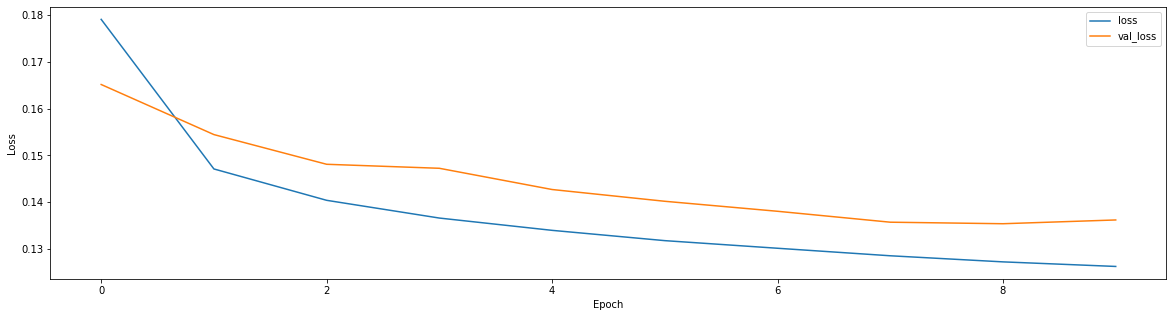

In [18]:
plt.plot(ann_model.history.history['loss'])
plt.plot(ann_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

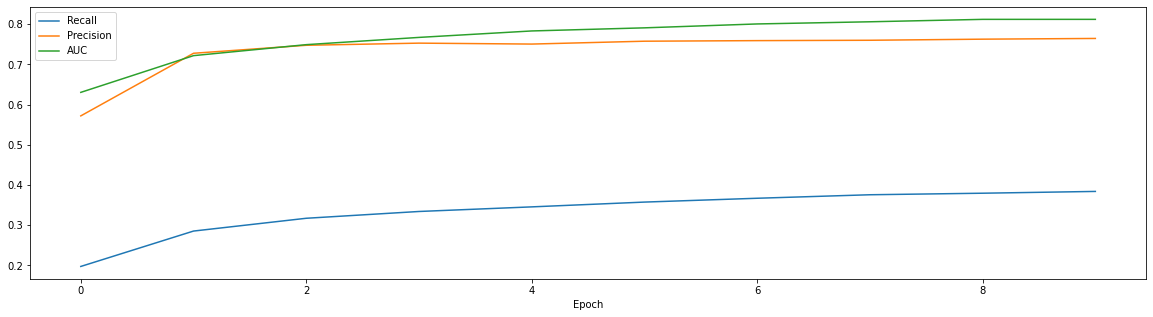

In [19]:
plt.plot(ann_model.history.history['Recall'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**CNN Models**

**lenet-5 Model**

In [20]:
lenet_5_model=Sequential()

lenet_5_model.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(1000,12)))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Conv1D(filters=16, strides=1, kernel_size=5))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(GlobalAveragePooling1D())

lenet_5_model.add(Dense(64, activation='relu'))

lenet_5_model.add(Dense(32, activation='relu'))

lenet_5_model.add(Dense(23, activation = 'sigmoid'))

In [21]:
lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [22]:
lenet_5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 6)           222       
                                                                 
 batch_normalization (BatchN  (None, 1000, 6)          24        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1000, 6)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 6)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 16)           496       
                                                                 
 batch_normalization_1 (Batc  (None, 496, 16)         

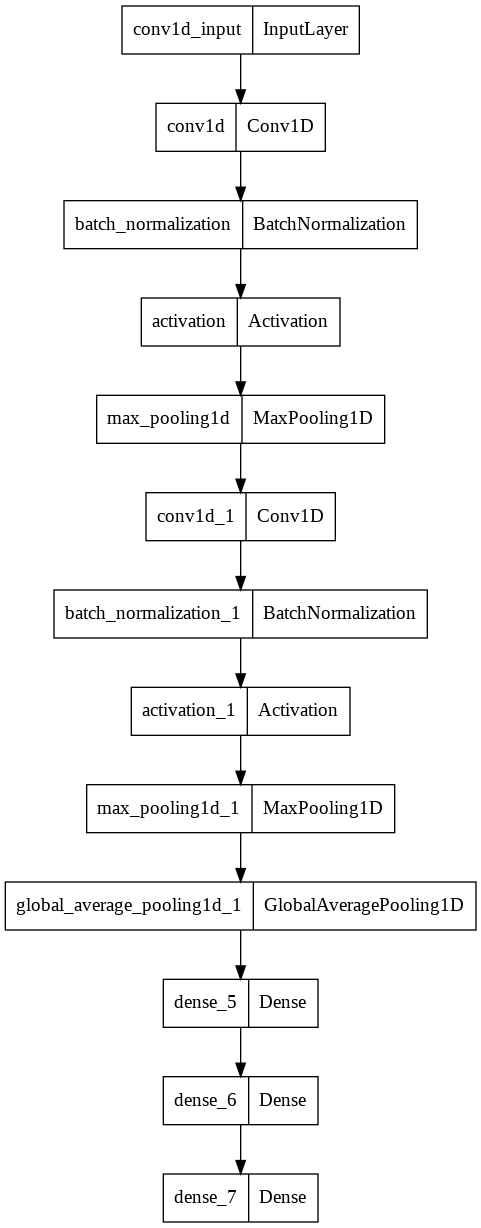

In [23]:
plot_model(lenet_5_model)

In [24]:
batchsize = 10
lenet_5_model.fit(x=signal, y=target, batch_size=batchsize, epochs=10, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/10
1396/1396 [==============================] - 26s 11ms/step - loss: 0.1797 - accuracy: 0.9389 - Recall: 0.1903 - Precision: 0.4803 - AUC: 0.6373 - val_loss: 0.1686 - val_accuracy: 0.9423 - val_Recall: 0.2432 - val_Precision: 0.5748 - val_AUC: 0.7081
Epoch 2/10
1396/1396 [==============================] - 13s 9ms/step - loss: 0.1476 - accuracy: 0.9500 - Recall: 0.2755 - Precision: 0.7211 - AUC: 0.7206 - val_loss: 0.1520 - val_accuracy: 0.9459 - val_Recall: 0.2778 - val_Precision: 0.6407 - val_AUC: 0.7584
Epoch 3/10
1396/1396 [==============================] - 12s 8ms/step - loss: 0.1397 - accuracy: 0.9518 - Recall: 0.3186 - Precision: 0.7272 - AUC: 0.7537 - val_loss: 0.1423 - val_accuracy: 0.9496 - val_Recall: 0.3031 - val_Precision: 0.7144 - val_AUC: 0.7697
Epoch 4/10
1396/1396 [==============================] - 12s 8ms/step - loss: 0.1351 - accuracy: 0.9525 - Recall: 0.3358 - Precision: 0.7279 - AUC: 0.7760 - val_loss: 0.1409 - val_accuracy: 0.9495 - val_Recall: 0.3215 - val

Text(0, 0.5, 'Accuracy')

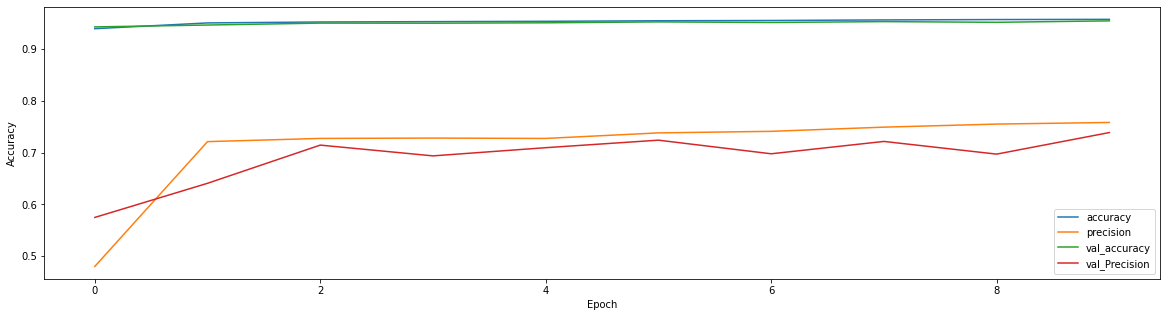

In [25]:
plt.plot(lenet_5_model.history.history['accuracy'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['val_accuracy'])
plt.plot(lenet_5_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

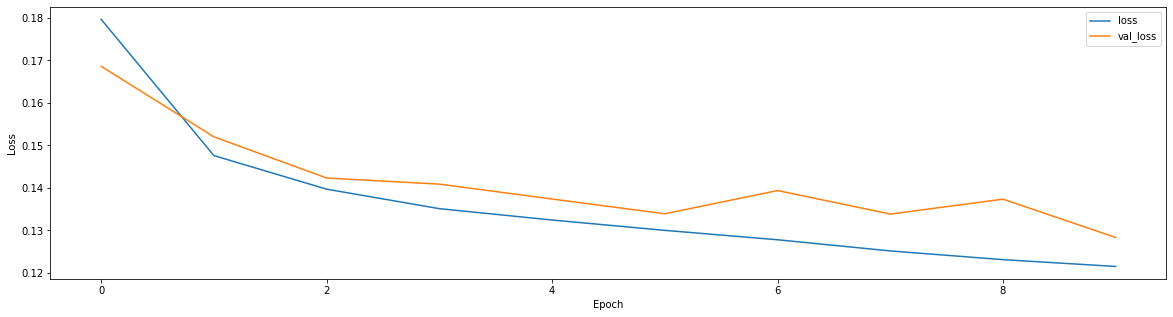

In [26]:
plt.plot(lenet_5_model.history.history['loss'])
plt.plot(lenet_5_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

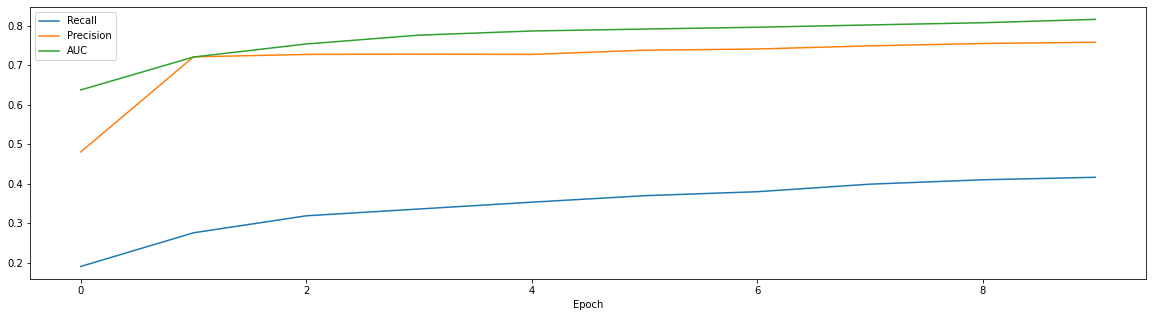

In [27]:
plt.plot(lenet_5_model.history.history['Recall'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**AlexNet Model**

In [28]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(1000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(23, activation='sigmoid'))

In [29]:
alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [30]:
alexNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 248, 96)           12768     
                                                                 
 batch_normalization_2 (Batc  (None, 248, 96)          384       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 248, 96)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 124, 96)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 124, 256)          123136    
                                                                 
 batch_normalization_3 (Batc  (None, 124, 256)        

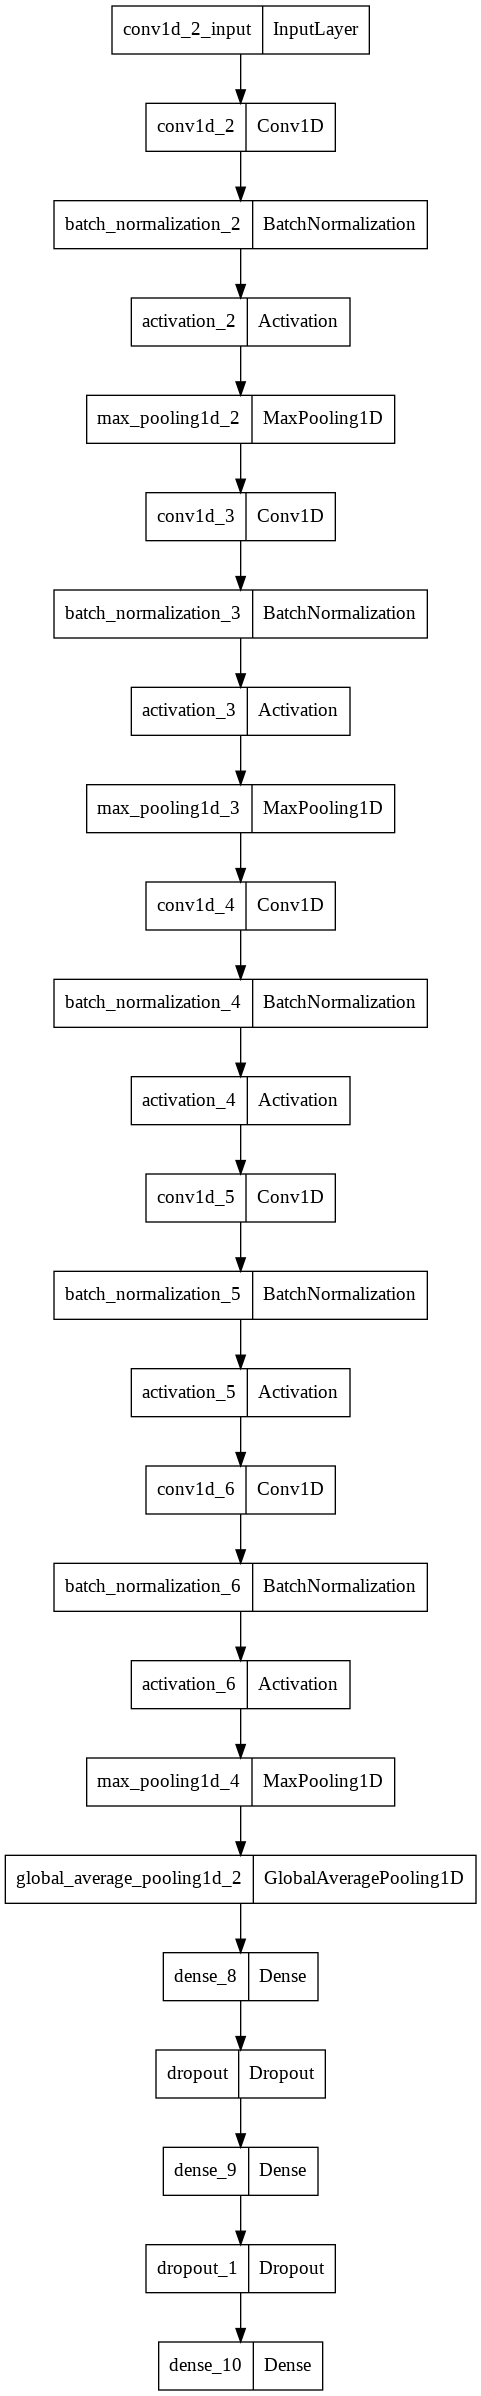

In [31]:
plot_model(alexNet_model)

In [32]:
batchsize = 10
alexNet_model.fit(x=signal, y=target, batch_size=batchsize, epochs=10, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/10
1396/1396 [==============================] - 23s 14ms/step - loss: 0.1583 - accuracy: 0.9476 - Recall: 0.3167 - Precision: 0.6279 - AUC: 0.7200 - val_loss: 0.1378 - val_accuracy: 0.9499 - val_Recall: 0.3648 - val_Precision: 0.6723 - val_AUC: 0.8040
Epoch 2/10
1396/1396 [==============================] - 19s 13ms/step - loss: 0.1347 - accuracy: 0.9541 - Recall: 0.3681 - Precision: 0.7366 - AUC: 0.7705 - val_loss: 0.1335 - val_accuracy: 0.9529 - val_Recall: 0.3998 - val_Precision: 0.7080 - val_AUC: 0.8038
Epoch 3/10
1396/1396 [==============================] - 18s 13ms/step - loss: 0.1261 - accuracy: 0.9561 - Recall: 0.4087 - Precision: 0.7474 - AUC: 0.7992 - val_loss: 0.1293 - val_accuracy: 0.9537 - val_Recall: 0.4152 - val_Precision: 0.7137 - val_AUC: 0.8282
Epoch 4/10
1396/1396 [==============================] - 18s 13ms/step - loss: 0.1209 - accuracy: 0.9584 - Recall: 0.4401 - Precision: 0.7699 - AUC: 0.8083 - val_loss: 0.1200 - val_accuracy: 0.9565 - val_Recall: 0.4535 - 

Text(0, 0.5, 'Accuracy')

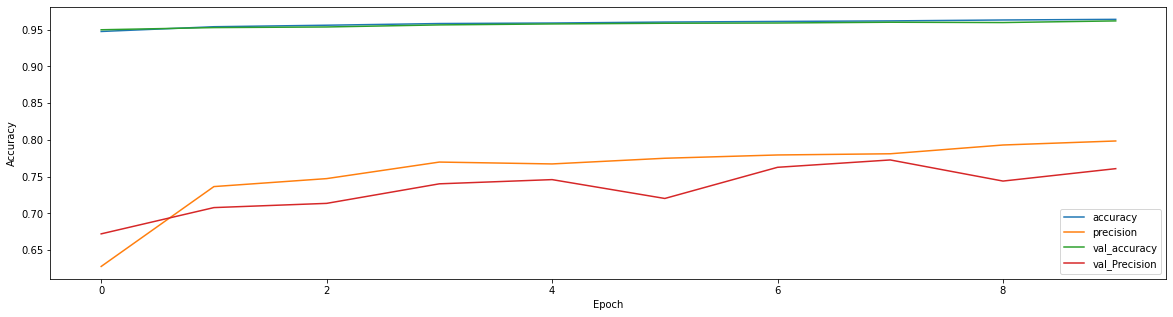

In [33]:
plt.plot(alexNet_model.history.history['accuracy'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['val_accuracy'])
plt.plot(alexNet_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

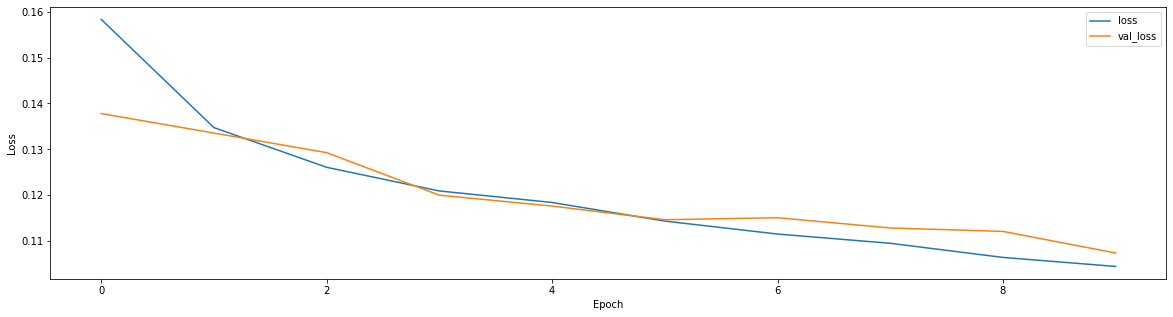

In [34]:
plt.plot(alexNet_model.history.history['loss'])
plt.plot(alexNet_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

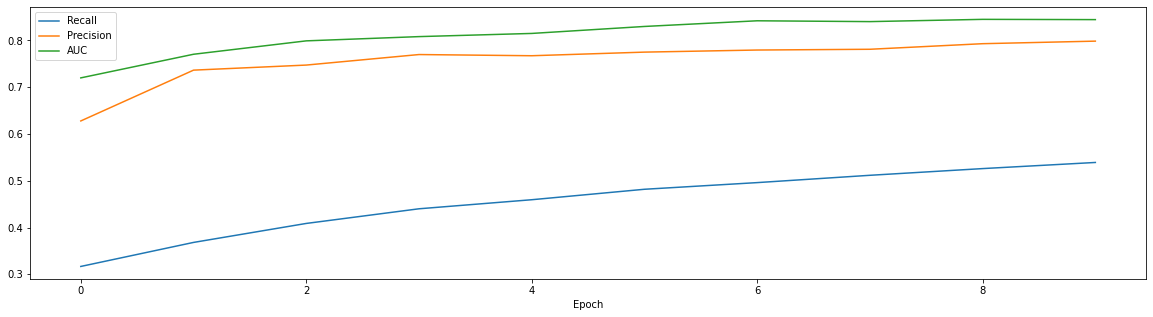

In [35]:
plt.plot(alexNet_model.history.history['Recall'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**VGG 16**

In [36]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same',  input_shape=(1000,12)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(GlobalAveragePooling1D())
vgg_16_model.add(Dense(256, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(128, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(23, activation='sigmoid'))

In [37]:
 vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [38]:
vgg_16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 1000, 64)          2368      
                                                                 
 batch_normalization_7 (Batc  (None, 1000, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 1000, 64)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 1000, 64)          12352     
                                                                 
 batch_normalization_8 (Batc  (None, 1000, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 1000, 64)         

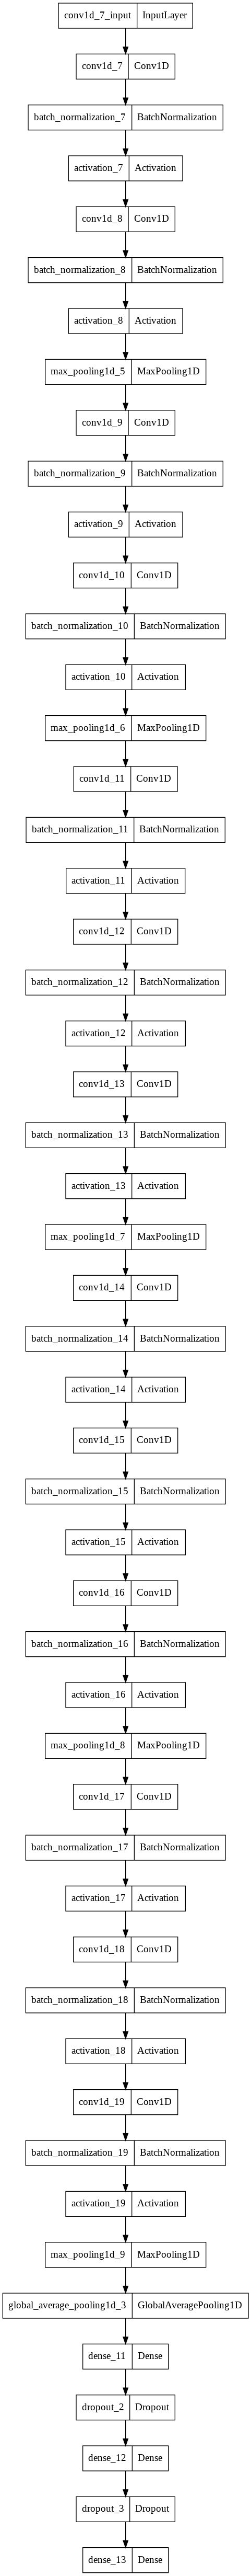

In [39]:
plot_model(vgg_16_model)

In [40]:
batchsize = 10
vgg_16_model.fit(x=signal, y=target, batch_size=batchsize, epochs=10, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/10
1396/1396 [==============================] - 45s 29ms/step - loss: 0.1649 - accuracy: 0.9467 - Recall: 0.2930 - Precision: 0.6219 - AUC: 0.6923 - val_loss: 0.1588 - val_accuracy: 0.9478 - val_Recall: 0.3205 - val_Precision: 0.6559 - val_AUC: 0.7484
Epoch 2/10
1396/1396 [==============================] - 40s 28ms/step - loss: 0.1412 - accuracy: 0.9528 - Recall: 0.3273 - Precision: 0.7457 - AUC: 0.7505 - val_loss: 0.1695 - val_accuracy: 0.9459 - val_Recall: 0.3252 - val_Precision: 0.6141 - val_AUC: 0.7631
Epoch 3/10
1396/1396 [==============================] - 40s 28ms/step - loss: 0.1341 - accuracy: 0.9538 - Recall: 0.3370 - Precision: 0.7615 - AUC: 0.7693 - val_loss: 0.1347 - val_accuracy: 0.9511 - val_Recall: 0.3490 - val_Precision: 0.7096 - val_AUC: 0.8200
Epoch 4/10
1396/1396 [==============================] - 39s 28ms/step - loss: 0.1300 - accuracy: 0.9547 - Recall: 0.3535 - Precision: 0.7675 - AUC: 0.7910 - val_loss: 0.1360 - val_accuracy: 0.9516 - val_Recall: 0.2942 - 

Text(0, 0.5, 'Accuracy')

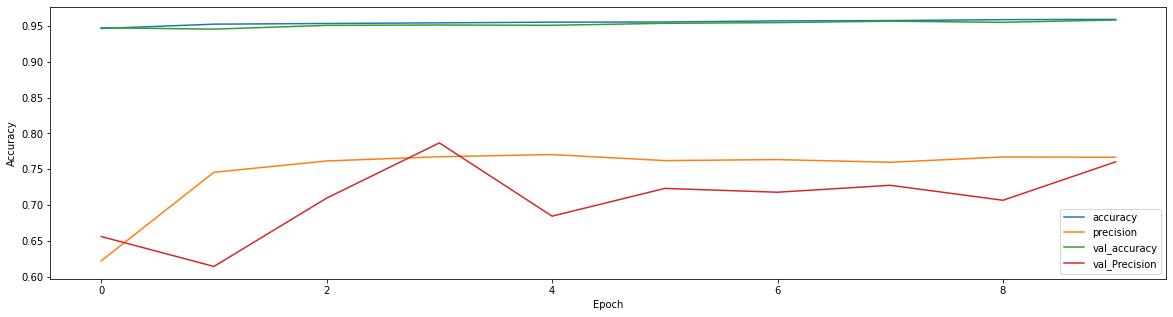

In [41]:
plt.plot(vgg_16_model.history.history['accuracy'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['val_accuracy'])
plt.plot(vgg_16_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

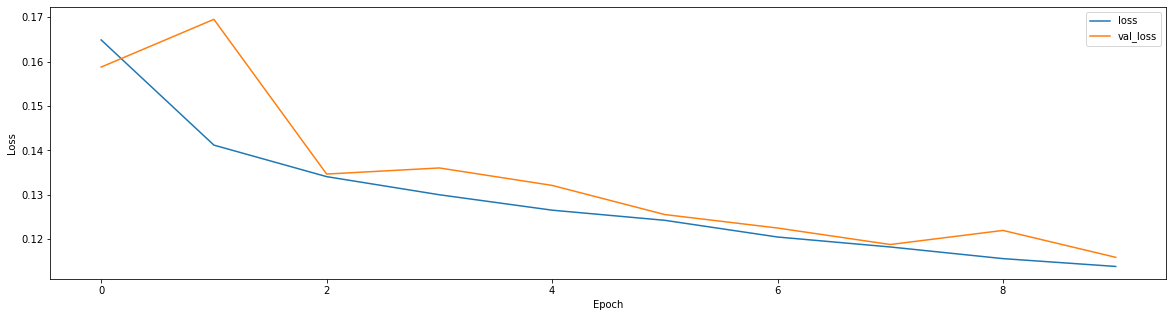

In [42]:
plt.plot(vgg_16_model.history.history['loss'])
plt.plot(vgg_16_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

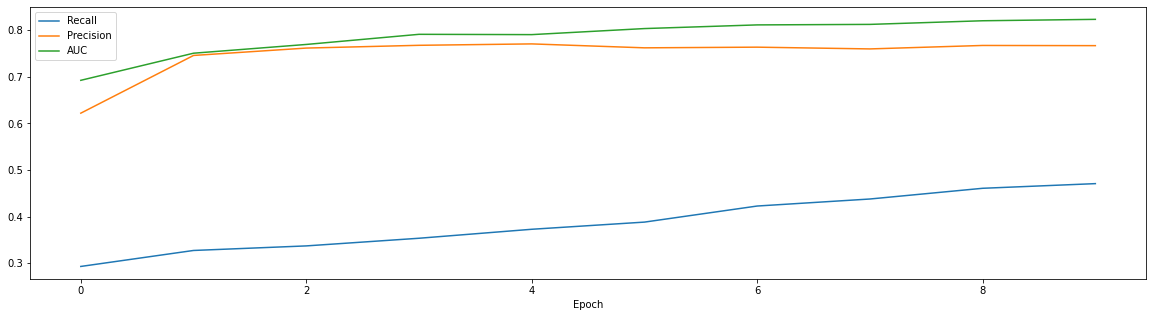

In [43]:
plt.plot(vgg_16_model.history.history['Recall'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**ResNet 50 Model**

In [44]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(23,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [45]:
resNet50_model = ResNet50(input_shape = (1000,12))

In [46]:
resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [47]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 1006, 12)    0           ['input_1[0][0]']                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 500, 64)      5440        ['zero_padding1d[0][0]']         
                                                                                                  
 batch_normalization_20 (BatchN  (None, 500, 64)     256         ['conv1d_20[0][0]']              
 ormalization)                                                                             

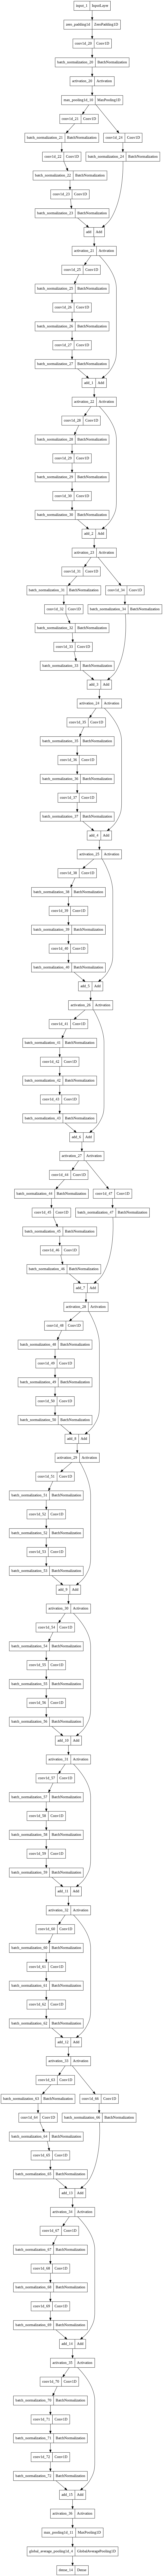

In [48]:
plot_model(resNet50_model)

In [49]:
batchsize = 10
resNet50_model.fit(x=signal, y=target, batch_size=batchsize, epochs=10, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/10
1396/1396 [==============================] - 121s 75ms/step - loss: 0.1843 - accuracy: 0.9446 - Recall: 0.2644 - Precision: 0.5890 - AUC: 0.6649 - val_loss: 0.3268 - val_accuracy: 0.9454 - val_Recall: 0.2582 - val_Precision: 0.6415 - val_AUC: 0.6896
Epoch 2/10
1396/1396 [==============================] - 100s 72ms/step - loss: 0.1490 - accuracy: 0.9509 - Recall: 0.3233 - Precision: 0.7000 - AUC: 0.7563 - val_loss: 0.1751 - val_accuracy: 0.9474 - val_Recall: 0.2513 - val_Precision: 0.7057 - val_AUC: 0.7512
Epoch 3/10
1396/1396 [==============================] - 98s 70ms/step - loss: 0.1478 - accuracy: 0.9516 - Recall: 0.3331 - Precision: 0.7072 - AUC: 0.7678 - val_loss: 1.4558 - val_accuracy: 0.9241 - val_Recall: 0.4189 - val_Precision: 0.3913 - val_AUC: 0.7041
Epoch 4/10
1396/1396 [==============================] - 99s 71ms/step - loss: 0.1338 - accuracy: 0.9541 - Recall: 0.3695 - Precision: 0.7360 - AUC: 0.7984 - val_loss: 0.1470 - val_accuracy: 0.9503 - val_Recall: 0.3889 

Text(0, 0.5, 'Accuracy')

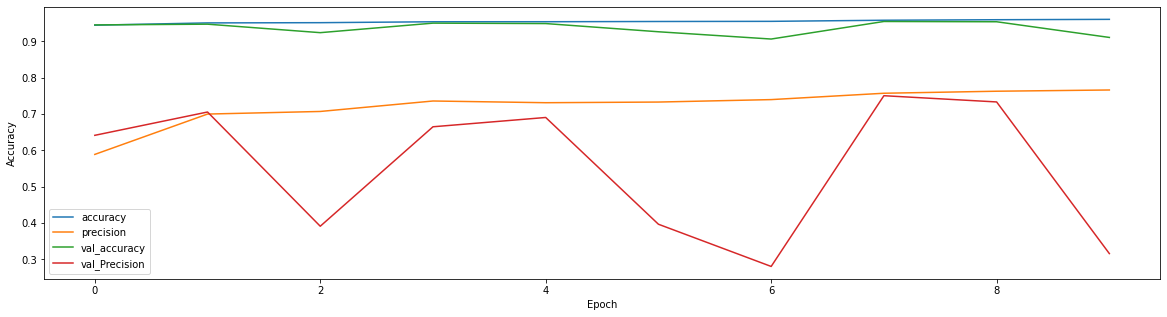

In [50]:
plt.plot(resNet50_model.history.history['accuracy'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['val_accuracy'])
plt.plot(resNet50_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

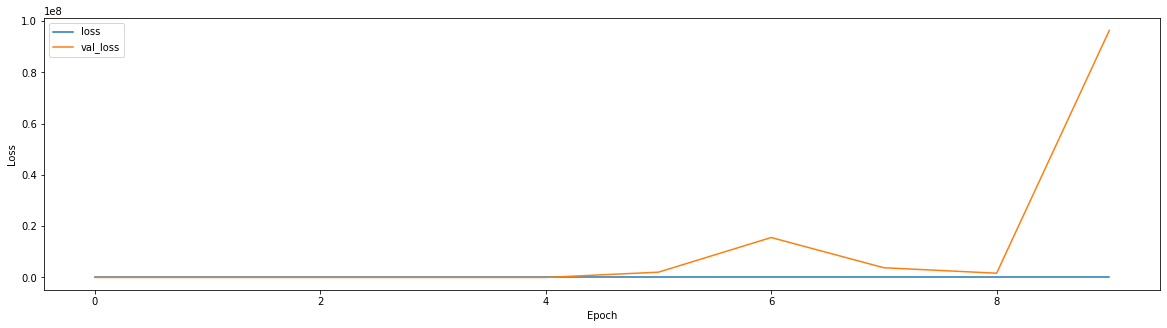

In [51]:
plt.plot(resNet50_model.history.history['loss'])
plt.plot(resNet50_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

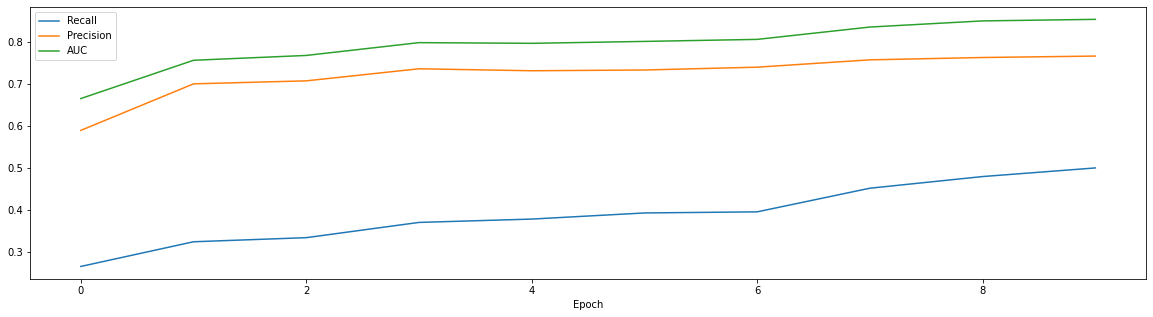

In [52]:
plt.plot(resNet50_model.history.history['Recall'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**Inseption Model**

In [53]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(23,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [54]:
inception_model = inception_model(input_shape = (1000,12))

In [55]:
inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [56]:
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 1006, 12)    0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_73 (Conv1D)             (None, 1006, 64)     5440        ['zero_padding1d_1[0][0]']       
                                                                                                  
 batch_normalization_73 (BatchN  (None, 1006, 64)    256         ['conv1d_73[0][0]']      

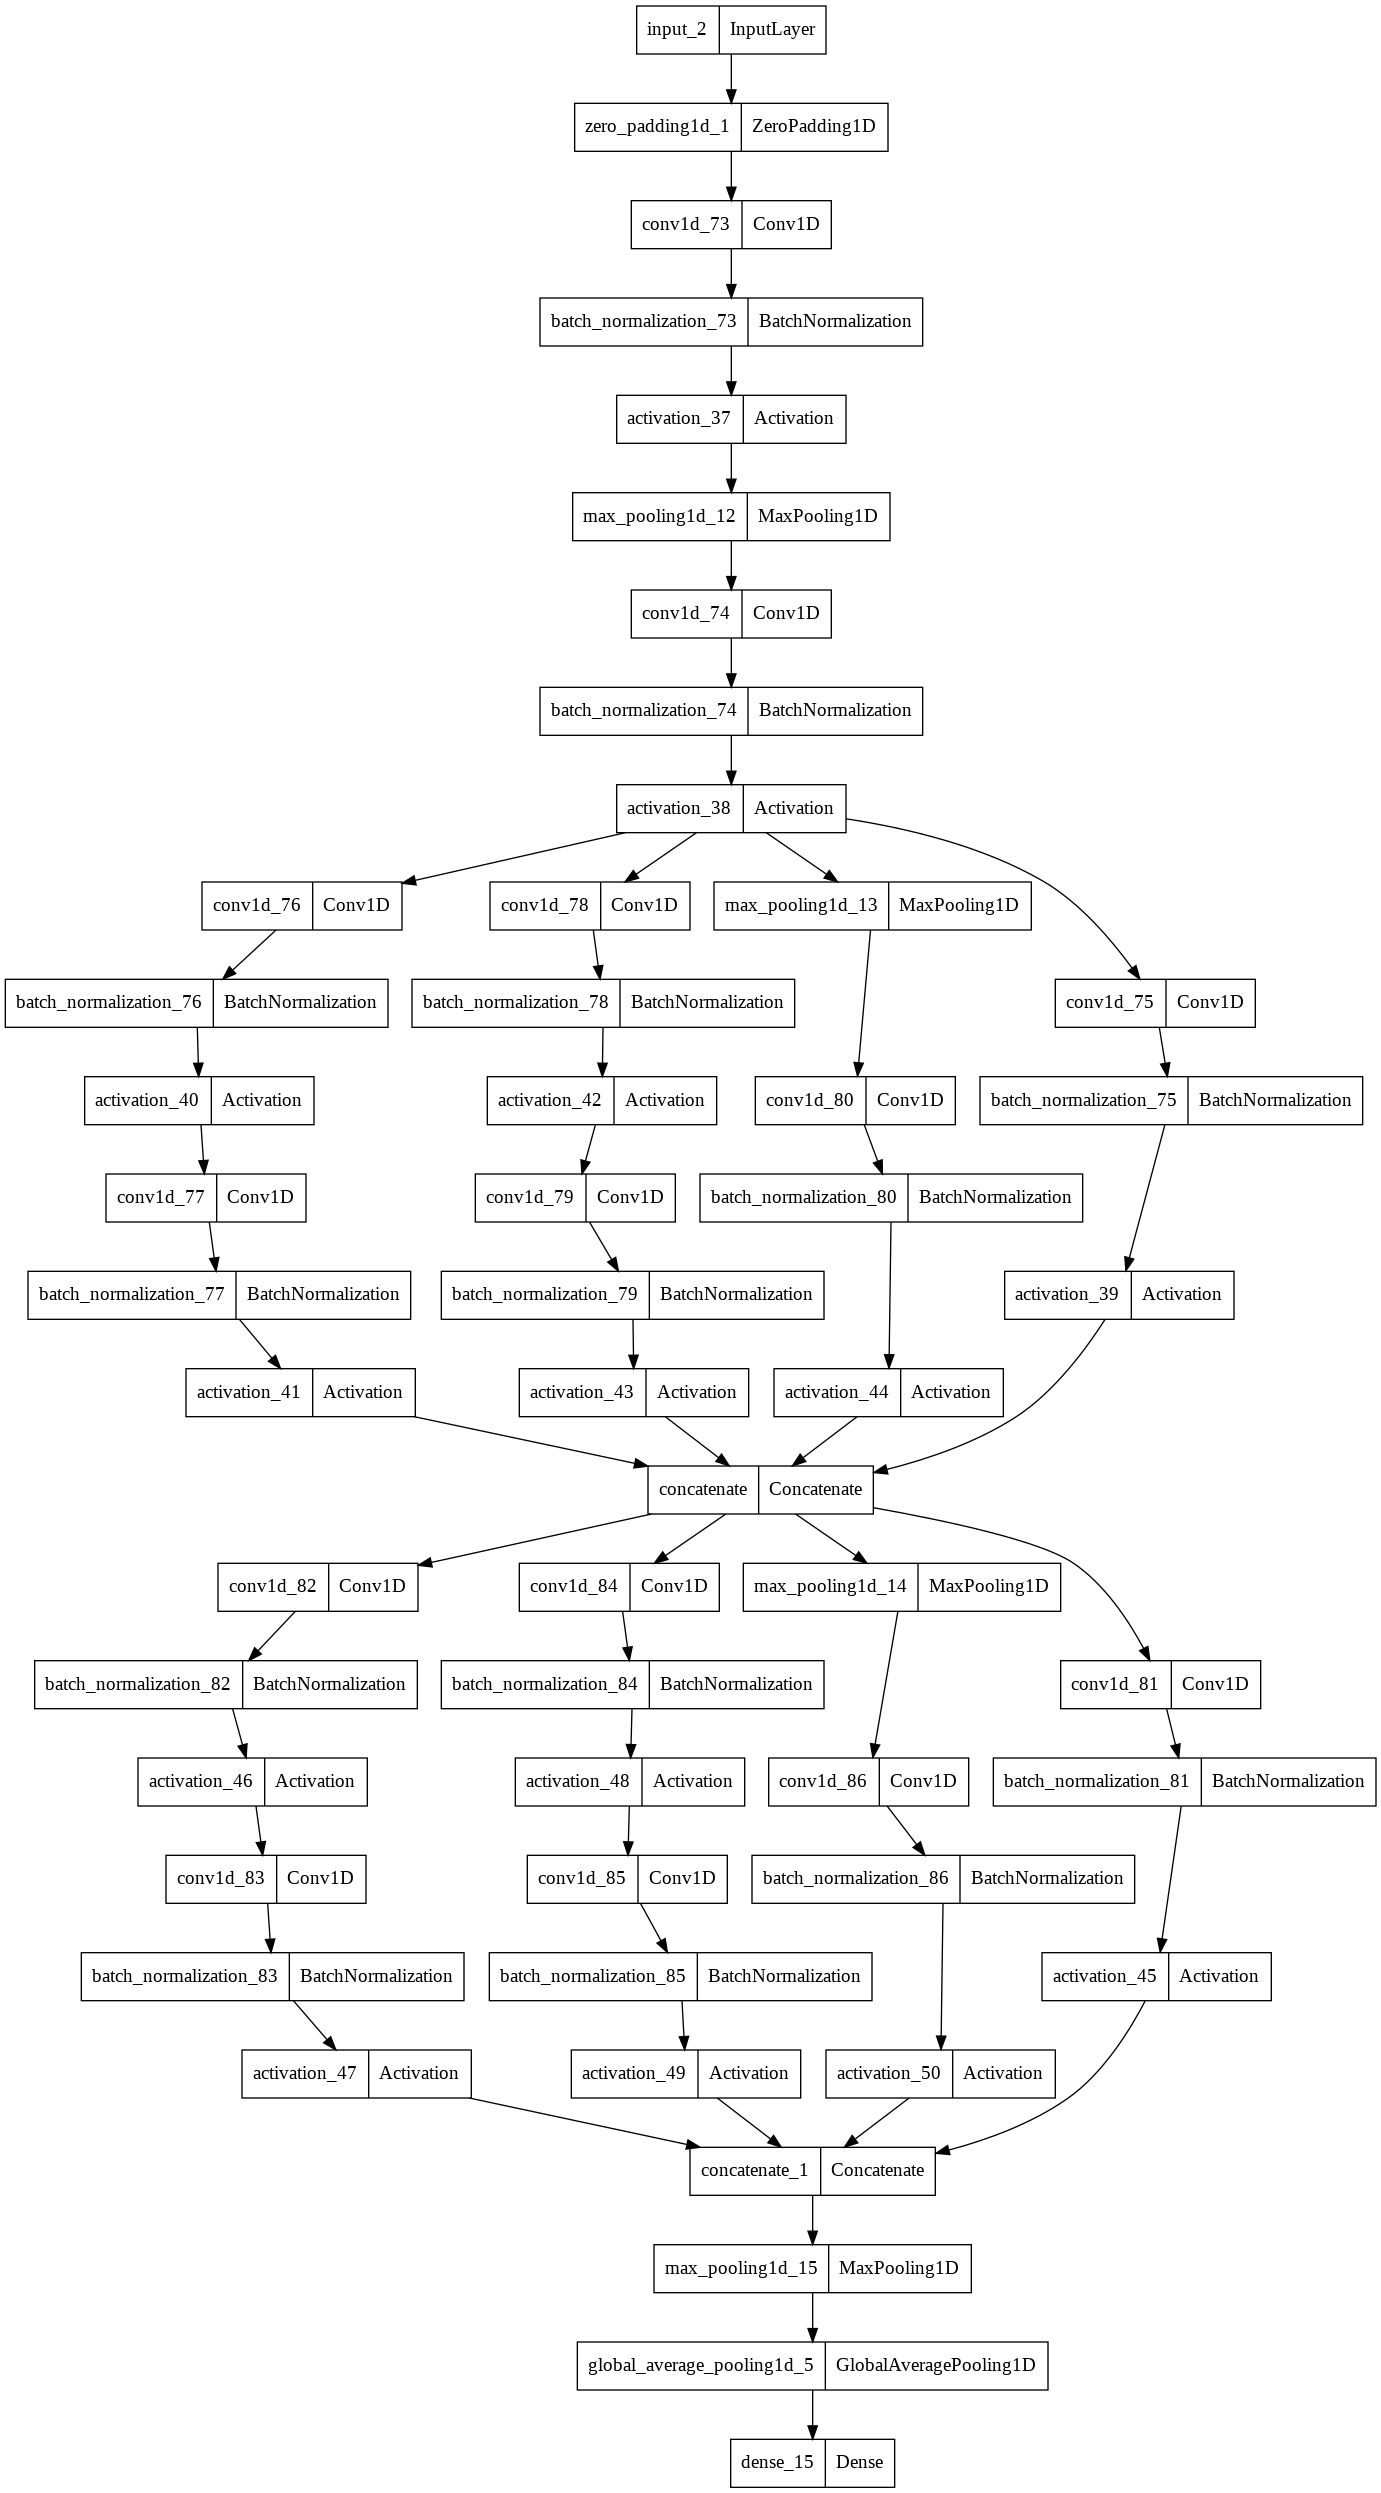

In [57]:
plot_model(inception_model)

In [58]:
batchsize = 10
inception_model.fit(x=signal, y=target, batch_size=batchsize, epochs=10, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/10
1396/1396 [==============================] - 46s 29ms/step - loss: 0.1464 - accuracy: 0.9493 - Recall: 0.3391 - Precision: 0.6503 - AUC: 0.7449 - val_loss: 0.1191 - val_accuracy: 0.9593 - val_Recall: 0.4616 - val_Precision: 0.7915 - val_AUC: 0.8042
Epoch 2/10
1396/1396 [==============================] - 39s 28ms/step - loss: 0.1120 - accuracy: 0.9606 - Recall: 0.4731 - Precision: 0.7873 - AUC: 0.8199 - val_loss: 0.1095 - val_accuracy: 0.9625 - val_Recall: 0.5291 - val_Precision: 0.7936 - val_AUC: 0.8416
Epoch 3/10
1396/1396 [==============================] - 39s 28ms/step - loss: 0.1051 - accuracy: 0.9627 - Recall: 0.5124 - Precision: 0.7951 - AUC: 0.8487 - val_loss: 0.1108 - val_accuracy: 0.9609 - val_Recall: 0.5150 - val_Precision: 0.7754 - val_AUC: 0.8614
Epoch 4/10
1396/1396 [==============================] - 39s 28ms/step - loss: 0.1012 - accuracy: 0.9641 - Recall: 0.5357 - Precision: 0.8019 - AUC: 0.8635 - val_loss: 0.1019 - val_accuracy: 0.9637 - val_Recall: 0.5781 - 

Text(0, 0.5, 'Accuracy')

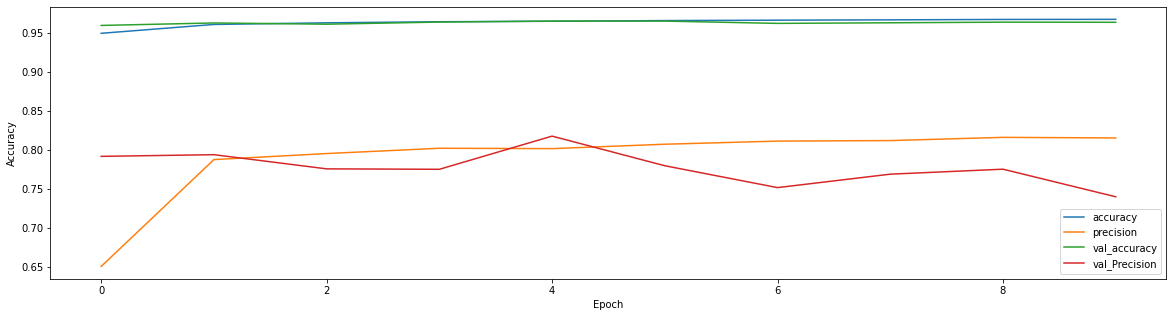

In [59]:
plt.plot(inception_model.history.history['accuracy'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

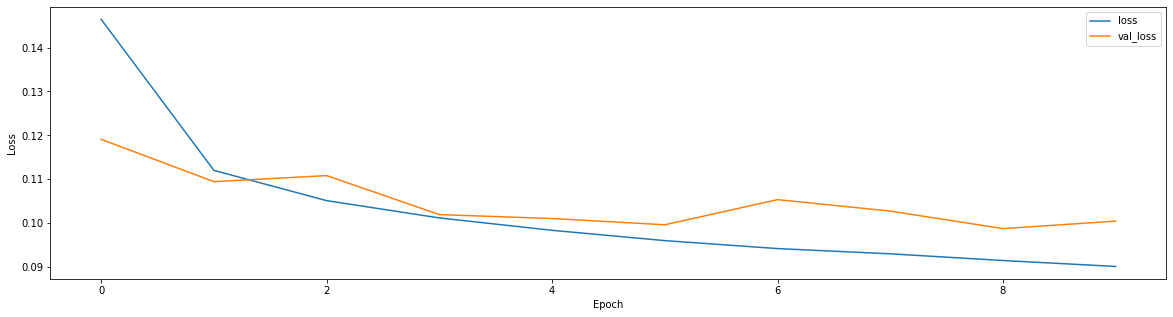

In [60]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

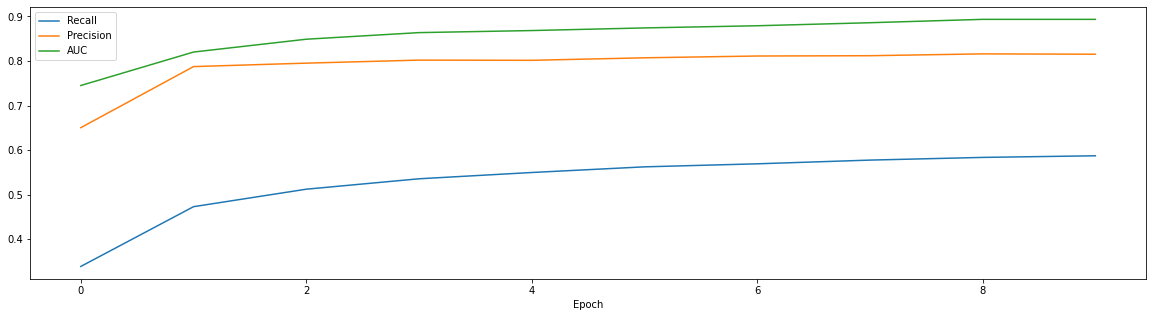

In [61]:
plt.plot(inception_model.history.history['Recall'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**RNN Model**

**LSTM Model**

In [62]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1000,12), return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(32, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(23, activation = 'sigmoid'))

In [63]:
 lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [64]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          19712     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 23)                759       
                                                                 
Total params: 55,575
Trainable params: 55,575
Non-trainable params: 0
_________________________________________________________________


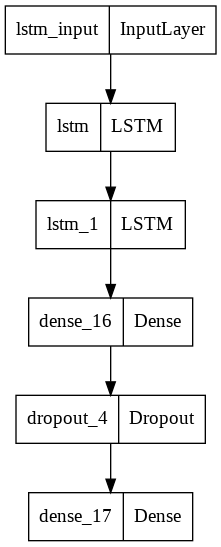

In [65]:
plot_model(lstm_model)

In [66]:
batchsize = 10
lstm_model.fit(x=signal, y=target, batch_size=batchsize, epochs=10, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/10
1396/1396 [==============================] - 108s 74ms/step - loss: 0.2027 - accuracy: 0.9323 - Recall: 0.0929 - Precision: 0.2983 - AUC: 0.5000 - val_loss: 0.1938 - val_accuracy: 0.9384 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AUC: 0.5006
Epoch 2/10
1396/1396 [==============================] - 106s 76ms/step - loss: 0.1824 - accuracy: 0.9392 - Recall: 0.0332 - Precision: 0.4335 - AUC: 0.5134 - val_loss: 0.1888 - val_accuracy: 0.9384 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AUC: 0.5551
Epoch 3/10
1396/1396 [==============================] - 103s 73ms/step - loss: 0.1814 - accuracy: 0.9397 - Recall: 0.0199 - Precision: 0.4782 - AUC: 0.5035 - val_loss: 0.1905 - val_accuracy: 0.9384 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AUC: 0.5032
Epoch 4/10
1396/1396 [==============================] - 102s 73ms/step - loss: 0.1809 - accuracy: 0.9398 - Recall: 0.0065 - Precision: 0.4826 - AUC: 0.4952 - val_loss: 0.1920 - val_accuracy: 0.

Text(0, 0.5, 'Accuracy')

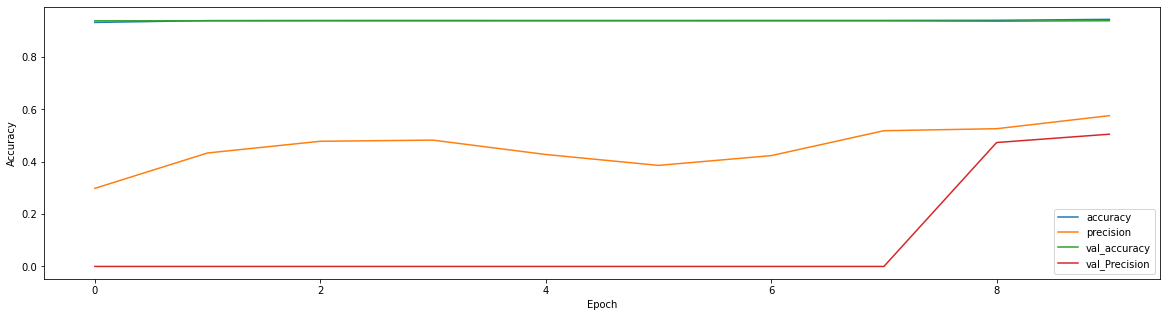

In [67]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

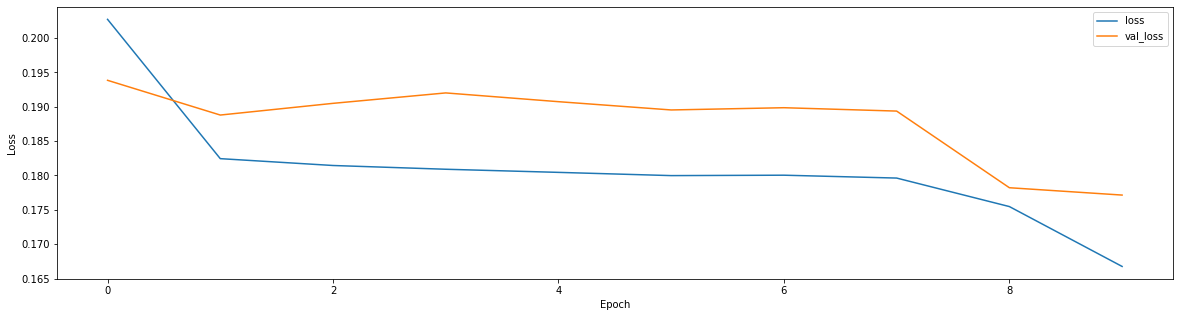

In [68]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

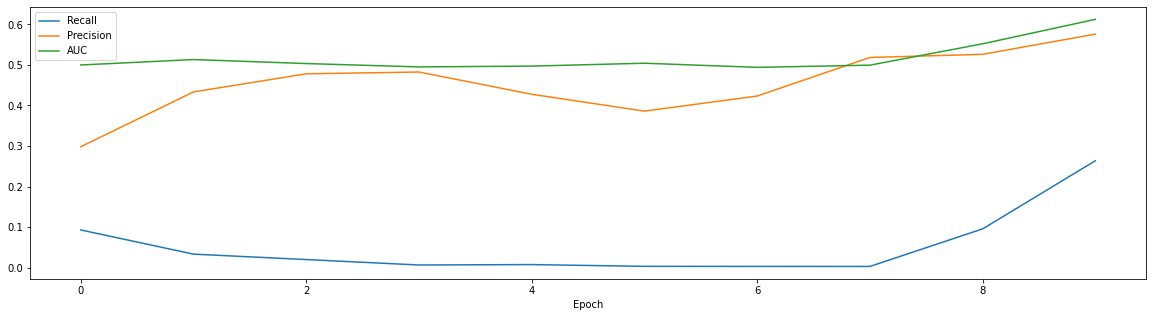

In [69]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')